In [109]:
import pandas as pd
import bs4
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

### data analysis

In [110]:

train_data = pd.read_csv("labeledTrainData.tsv.zip", sep='\t', quoting=3, header=0)
print("this is the labled dataset")
print(train_data.head())
print("Shape of labled dataset :", train_data.shape)

test_data = pd.read_csv("testData.tsv.zip", sep='\t', quoting=3, header=0)
print("\nthis is the test dataset")
print(test_data.head())
print("Shape of test dataset :", test_data.shape)


this is the labled dataset
         id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...
Shape of labled dataset : (25000, 3)

this is the test dataset
           id                                             review
0  "12311_10"  "Naturally in a film who's main themes are of ...
1    "8348_2"  "This movie is a disaster within a disaster fi...
2    "5828_4"  "All in all, this is a movie for kids. We saw ...
3    "7186_2"  "Afraid of the Dark left me with the impressio...
4   "12128_7"  "A very accurate depiction of small time mob l...
Shape of test dataset : (25000, 2)


## Part 1 : Bag of Words

In [111]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['sentiment']), train_data.sentiment, test_size=0.2, random_state=3)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [112]:
X_train.head()

,id,review
0,"""9143_2""","""as an actor I really like independent films b..."
1,"""5181_3""","""This is the first film of the Horrorfest I ha..."
2,"""5003_4""","""I'm embarrassed to be writing this review. I ..."
3,"""5563_8""","""The opening sequence alone is worth the cost ..."
4,"""2603_8""","""Unfortunately, the director Amos Guttman died..."


In [113]:
X_test.head()

,id,review
0,"""2033_1""","""If I could give it less that 1 I would. Do no..."
1,"""10228_3""","""To be honest i had heard this was pretty bad ..."
2,"""5105_4""","""I guess there are some out there that remembe..."
3,"""11637_4""","""Uwe Boll has done the impossible: create a ga..."
4,"""70_9""","""What a surprise; two outstanding performances..."


### preprocessing and cleaning

In [114]:
def review_to_words(review, string = True, remove_stopwords=True):
    review_text = bs4.BeautifulSoup(review).get_text()
    review_text = re.sub(r"[^A-Za-z]", " ", review_text)
    
    words = review_text.lower().split()
    if remove_stopwords:
        stops_wrds = set(stopwords.words("english"))
        words = [w for w in words if not w in stops_wrds]
    if string:
        return " ".join(words)
    else:
        return words

In [115]:
clean_trainData_reviews = X_train['review'].apply(review_to_words)
clean_testData_reviews = X_test['review'].apply(review_to_words)

In [116]:
clean_trainData_reviews[0:2]

0    actor really like independent films one amateu...
1    first film horrorfest watched im almost thinki...
Name: review, dtype: object

In [117]:
clean_testData_reviews[0:2]

0    could give less would bother rent someone give...
1    honest heard pretty bad decided watch never on...
Name: review, dtype: object

In [118]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=None,stop_words=None,preprocessor=None, max_features=9000)

train_features = vectorizer.fit_transform(clean_trainData_reviews).toarray()
test_features = vectorizer.transform(clean_testData_reviews).toarray()

In [119]:
vocab = vectorizer.get_feature_names()
print(vocab[0:20])

['aaron', 'abandon', 'abandoned', 'abc', 'abilities', 'ability', 'able', 'aboard', 'abomination', 'abortion', 'abound', 'abraham', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorbed', 'absorbing']


### Making Models

In [120]:

def get_predictions(test_feat, train_feat, y_test, y_train, model, title='Random Forest'):
    model.fit(train_feat, y_train)
    predictions = model.predict(test_feat)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    print("confusion matrix :\n", confusion_matrix(y_test, predictions))
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    return predictions

Accuracy before tf-idf term frequency - inverse document frequency

AUC: 0.8506461338772305
confusion matrix :
 [[2129  354]
 [ 393 2124]]


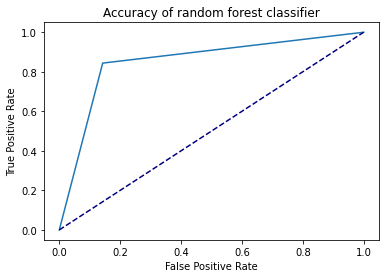

In [121]:
rf_predictions = get_predictions(test_features, train_features, y_test, y_train, RandomForestClassifier(n_estimators=100, random_state=34), "Accuracy of random forest classifier")

AUC: 0.8542571808520426
confusion matrix :
 [[2142  341]
 [ 388 2129]]


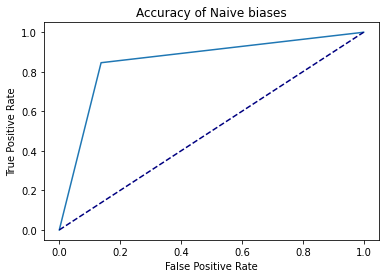

In [122]:
nb_predictions = get_predictions(test_features, train_features, y_test, y_train, MultinomialNB(), "Accuracy of Naive biases")

### Tf-Idf

In [123]:
tfidf_transformer = TfidfTransformer().fit(train_features)
train_tfidf = tfidf_transformer.transform(train_features)

test_tfidf = tfidf_transformer.transform(test_features)

Accuracy after tf-idf term frequency - inverse document frequency

AUC: 0.8532666550501294
confusion matrix :
 [[2143  340]
 [ 394 2123]]


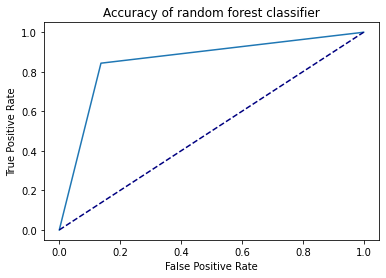

In [124]:
rf_predictions = get_predictions(test_tfidf, train_tfidf, y_test, y_train, RandomForestClassifier(n_estimators=100, random_state=34), "Accuracy of random forest classifier")

AUC: 0.8608126039748077
confusion matrix :
 [[2142  341]
 [ 355 2162]]


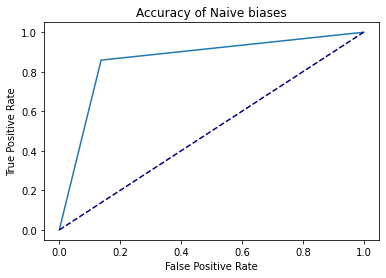

In [125]:
nb_predictions = get_predictions(test_tfidf, train_tfidf, y_test, y_train, MultinomialNB(), "Accuracy of Naive biases")